In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from database.adatabase import ADatabase
from tqdm import tqdm
from processor.processor import Processor as p

In [2]:
market = ADatabase("market")

In [4]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()

In [5]:
index

,ticker,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
497,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [93]:
prices = []
market.connect()
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["signal"] = (price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean())
        prices.append(price)
    except:
        continue
market.disconnect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:30<00:00, 16.62it/s]


In [94]:
sim = pd.concat(prices).sort_values("date").dropna()

In [95]:
dates = list(sim["date"].unique())

In [101]:
base_port = {"date":dates[0],"cash":100,"ticker":"","purchase_price":0,"adjclose":0,"quantity":0,"direction":1}

In [116]:
portfolio = base_port.copy()
portfolios = []
for date in tqdm(dates[-1000:]):
    today = sim[sim["date"]==date]
    portfolio["date"] = date
    if portfolio["ticker"] != "":
        ticker_data = today[today["ticker"]==portfolio["ticker"]]
        if ticker_data.index.size > 0:
            portfolio["adjclose"] = ticker_data["adjclose"].item()
            pnl = (portfolio["adjclose"] / portfolio["purchase_price"] - 1) * 4 * portfolio["direction"]
            if pnl >= 0.2:
                cash = portfolio["adjclose"] * portfolio["quantity"]
                portfolio = base_port.copy()
                portfolio["cash"] = cash
                portfolio["date"] = date
            elif pnl <= -0.1:
                cash = portfolio["adjclose"] * portfolio["quantity"]
                portfolio = base_port.copy()
                portfolio["cash"] = cash
                portfolio["date"] = date
            
    else:
        if portfolio["cash"] > 0:
            opportunity = today.sort_values("signal",ascending=True).iloc[0]
            portfolio["date"] = date
            portfolio["ticker"] = opportunity["ticker"]
            portfolio["adjclose"] = opportunity["adjclose"]
            portfolio["purchase_price"] = opportunity["adjclose"]
            portfolio["quantity"] = portfolio["cash"] / portfolio["adjclose"]
            portfolio["cash"] = 0
    portfolios.append(portfolio.copy())
    
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 176.23it/s]


In [117]:
states

,date,cash,ticker,purchase_price,adjclose,quantity,direction,pv
0,2011-05-16,0.0,MTB,58.752941,58.752941,1.702042,1,100.000000
1,2011-05-17,0.0,MTB,58.752941,59.813635,1.702042,1,101.805347
2,2011-05-18,0.0,MTB,58.752941,60.772339,1.702042,1,103.437102
3,2011-05-19,0.0,MTB,58.752941,60.629553,1.702042,1,103.194075
4,2011-05-20,0.0,MTB,58.752941,59.861230,1.702042,1,101.886356
...,...,...,...,...,...,...,...,...
3419,2024-12-16,0.0,BDX,221.606545,227.560000,2.535866,1,577.061742
3420,2024-12-17,0.0,BDX,221.606545,225.640000,2.535866,1,572.192878
3421,2024-12-18,0.0,BDX,221.606545,224.090000,2.535866,1,568.262285
3422,2024-12-19,0.0,BDX,221.606545,223.830000,2.535866,1,567.602960


In [118]:
states = pd.DataFrame(portfolios)
states["pv"] = states["cash"] + states["adjclose"] * states["quantity"]
states.dropna(inplace=True)

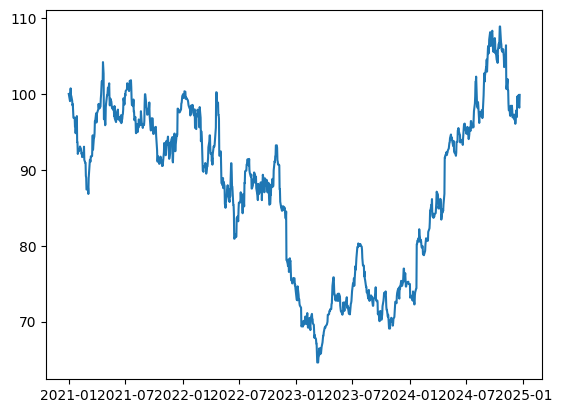

In [119]:
plt.plot(states["date"].values,states["pv"].values)